In [138]:
# Import Libraries
import datetime as dt
import pandas as pd
import re
import numpy as np
import nltk
import regex as reg
import matplotlib.pyplot as plt

from twitterscraper import query_tweets
from sklearn.decomposition import LatentDirichletAllocation as LDA
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import stop_words
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_multilabel_classification
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from bs4 import BeautifulSoup

%config InlineBackend.figure_format = 'retina'
plt.style.use('fivethirtyeight')
%matplotlib inline

pd.set_option('display.max_colwidth',-1)
pd.set_option('display.max_rows', 1500)
pd.set_option('display.max_columns', 500)

## EXPLORATORY DATA ANALYSIS ALL LABELED TWEETS FIRE & HURRICANE

In [139]:
# Import data
df =pd.read_csv('../data/df8_SUPER.csv')

In [140]:
# Select the 3 columns that we are interested in.
df=df[['text','requesting_help','disaster']]

In [141]:
# Set X to the text column and y to the requesting_help column.
X = df['text']
y= df['requesting_help']

In [142]:
# Group by disaster and then requesting help to get the count of requesting help for each disaster.
df.groupby('disaster')['requesting_help'].value_counts()

disaster   requesting_help
fire       0                  427
           1                  75 
hurricane  0                  351
           1                  153
Name: requesting_help, dtype: int64

In [143]:
# Baseline calculation
df['requesting_help'].value_counts(normalize=True)

0    0.77336
1    0.22664
Name: requesting_help, dtype: float64

## MODELING

In [144]:
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y, random_state=42)

## LOGISTIC REGRESSION WITH COUNT VECTORIZER

In [145]:
# Instantiate Pipline for Logistic Regression using Count Vectorizer
# Found this terrific website that explains the different solver options in LogisticRegression
# https://towardsdatascience.com/dont-sweat-the-solver-stuff-aea7cddc3451
pipe_a = Pipeline([
    ('cvec_a', CountVectorizer()),
    ('lr_a', LogisticRegression(solver= 'lbfgs'))
])

params_a = {
    'cvec_a__max_features': [2000, 3000, 4000, 5000],
    'cvec_a__min_df': [2, 3],
    'cvec_a__max_df': [.9, .95],
    'cvec_a__ngram_range': [(1,1), (1,4)],
    'cvec_a__stop_words':['english', None]
}

gs_a = GridSearchCV(pipe_a,params_a, cv=5, n_jobs=3)
    
gs_a.fit(X_train, y_train)
    
print(f'Gridsearch with Count Vectorizer for training data is {gs_a.score(X_train, y_train)}')
print()
print(f'Gridsearch with Count Vectorizer for test data is {gs_a.score(X_test, y_test)}')

Gridsearch with Count Vectorizer for training data is 0.993368700265252

Gridsearch with Count Vectorizer for test data is 0.8928571428571429


In [146]:
gs_a.best_params_

{'cvec_a__max_df': 0.9,
 'cvec_a__max_features': 2000,
 'cvec_a__min_df': 2,
 'cvec_a__ngram_range': (1, 1),
 'cvec_a__stop_words': None}

In [147]:
#print(f'Logistic Regression Intercept: {logreg.intercept_}')
#print(f'Logistic Regression Coefficient: {logreg.coef_}')
# Find Intercept and coefficient. From lesson 4.01
#print(f'Intercept is {lr_a.intercept_}')
#print(f'Coefficient is {lr_a.coef_}')

## LOGISTIC REGRESSION WITH TFIDF VECTORIZER

In [148]:
pipe_b = Pipeline([
    ('tfid_b', TfidfVectorizer()),
    ('lr_b', LogisticRegression(solver= 'lbfgs'))
])

params_b = {
    'tfid_b__max_features': [2000, 3000, 4000, 5000],
    'tfid_b__min_df': [2, 3],
    'tfid_b__max_df': [.9, .95],
    'tfid_b__ngram_range': [(1,1), (1,4)],
    'tfid_b__stop_words':['english', None]
}

gs_b = GridSearchCV(pipe_b,params_b, cv=5, n_jobs=3)
    
gs_b.fit(X_train, y_train)
    
print(f'Gridsearch with TFIDF Vectorizer for training data is {gs_b.score(X_train, y_train)}')
print()
print(f'Gridsearch with TFIDF Vectorizer for test data is {gs_b.score(X_test, y_test)}')

Gridsearch with TFIDF Vectorizer for training data is 0.8952254641909815

Gridsearch with TFIDF Vectorizer for test data is 0.8650793650793651


In [149]:
gs_b.best_params_

{'tfid_b__max_df': 0.9,
 'tfid_b__max_features': 2000,
 'tfid_b__min_df': 3,
 'tfid_b__ngram_range': (1, 1),
 'tfid_b__stop_words': 'english'}

In [150]:
gs_b.best_estimator_

Pipeline(memory=None,
         steps=[('tfid_b',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.9, max_features=2000,
                                 min_df=3, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('lr_b',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_

In [151]:
gs_b_best = gs_b.best_estimator_

In [152]:
# pull coefficients for model
coefs = gs_b_best.named_steps['lr_b'].coef_[0]

In [153]:

# get feature names
features = gs_b_best.named_steps['tfid_b'].get_feature_names()

In [154]:
# create df
simple_df = pd.DataFrame({"features": features,
                         "coefficients": coefs,
                         "absolute_coefs": np.abs(coefs)})

In [156]:
pwd

'/Users/Brian 1/Desktop/GA_12.10_1.04/shelter_status/code'

FileNotFoundError: [Errno 2] No such file or directory: '../visuals/feature_coefs_lr.png'

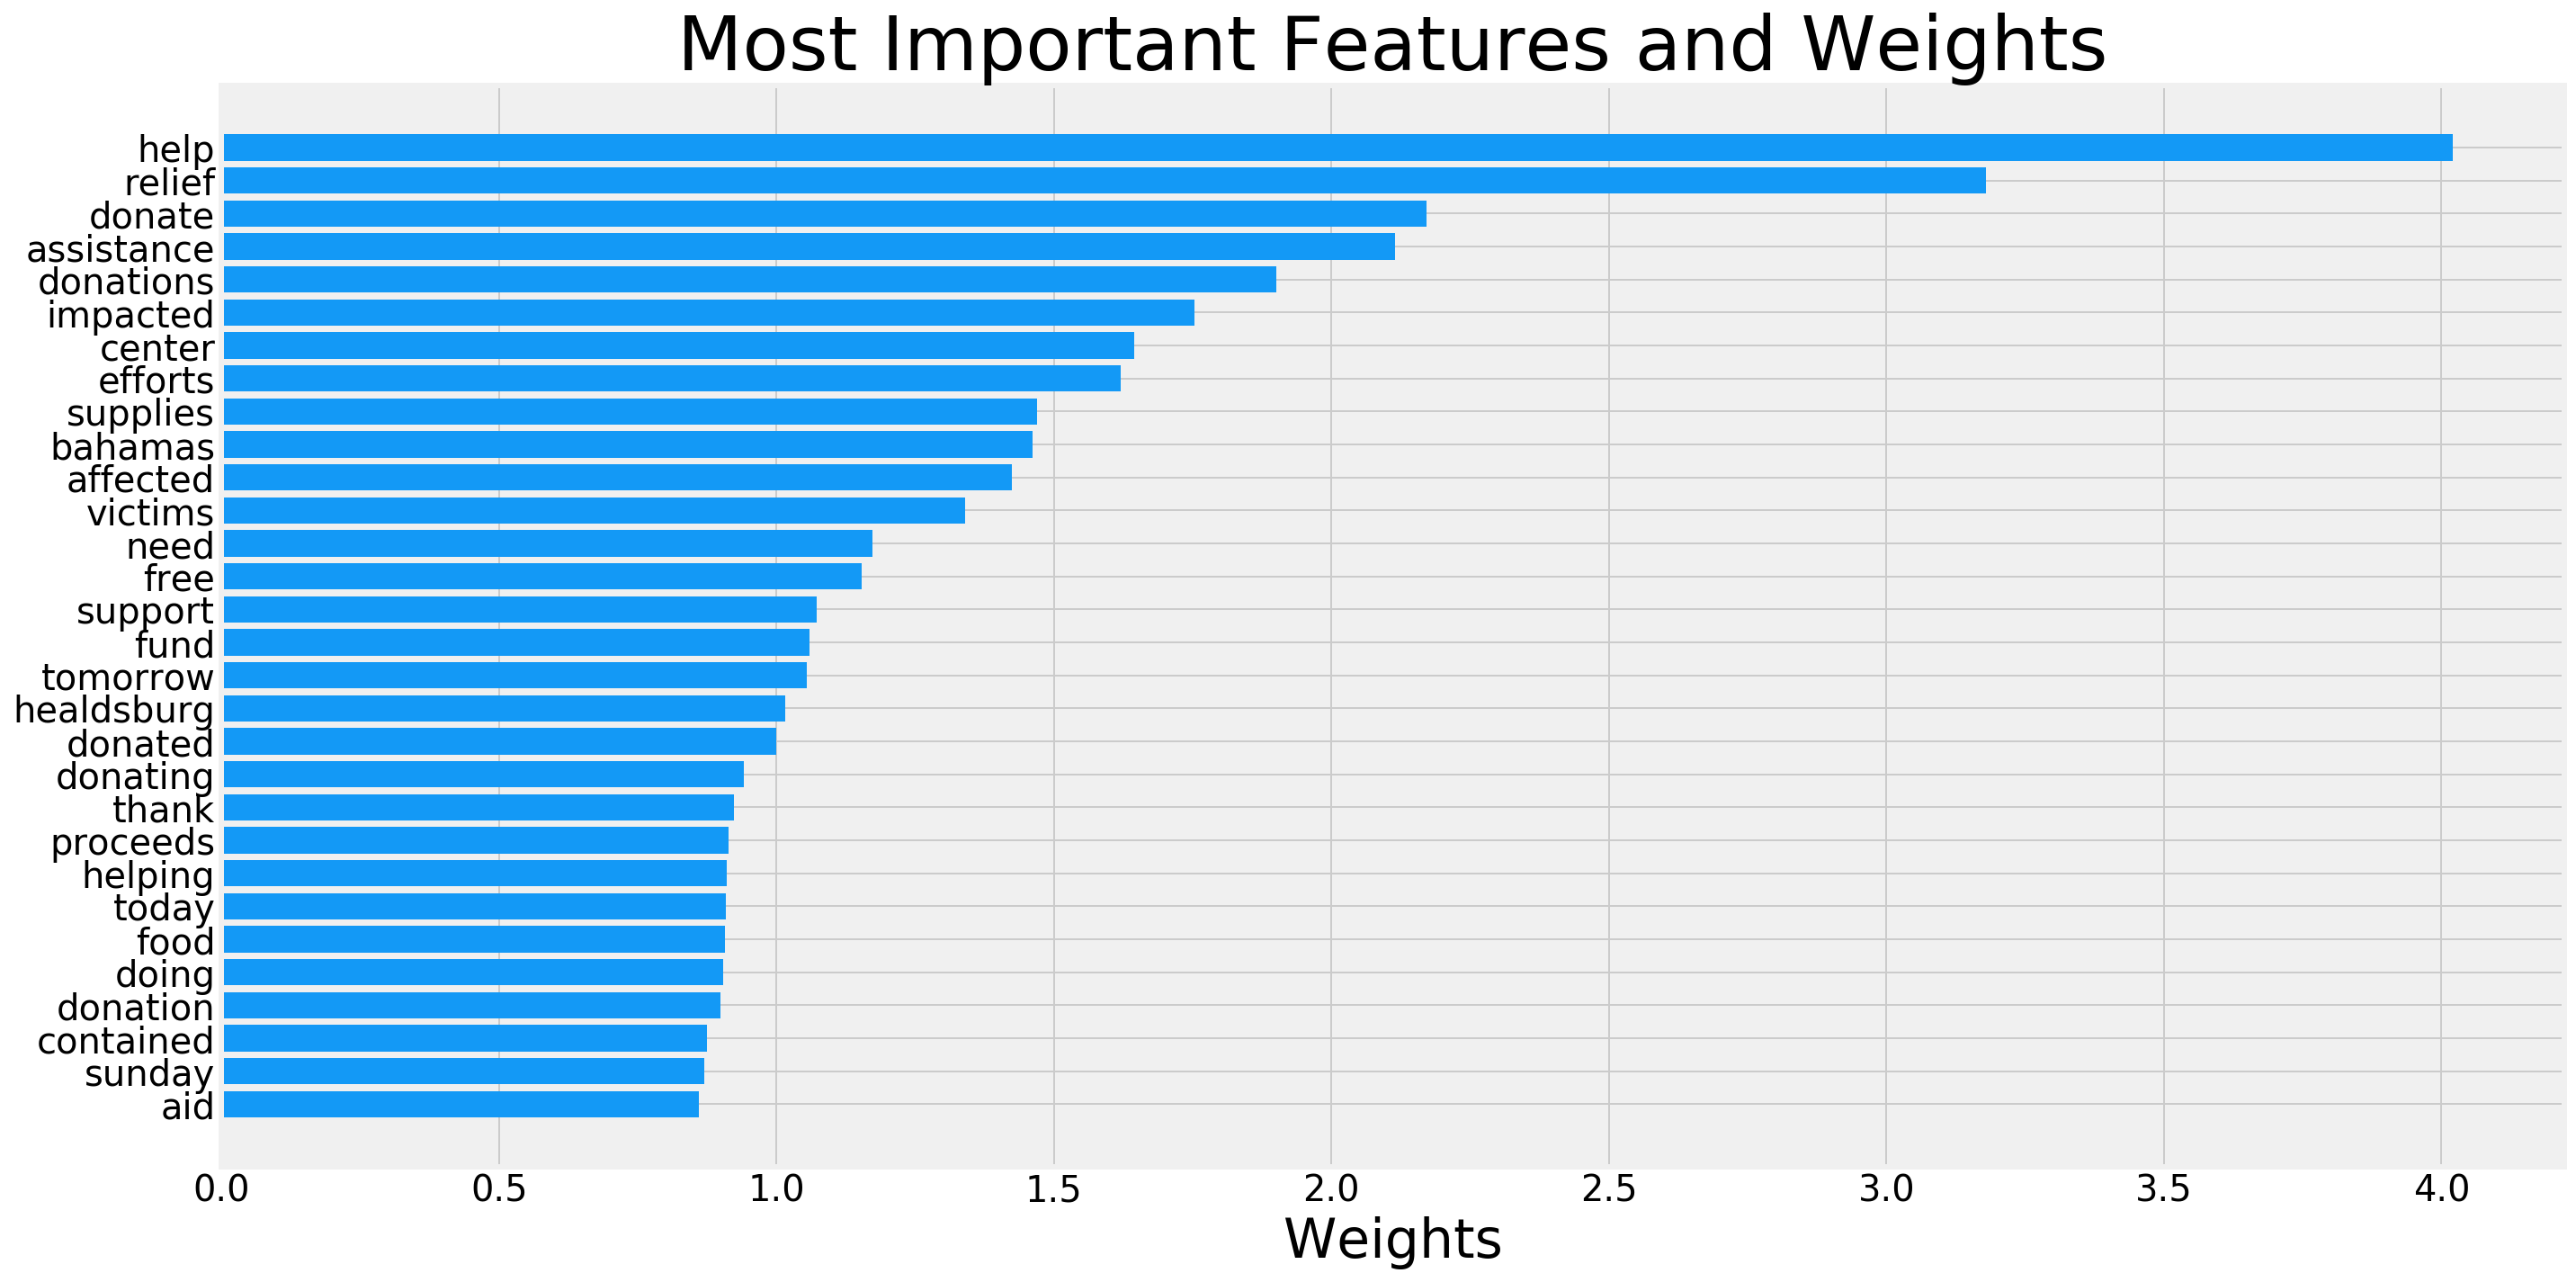

In [155]:
# graph in bar chart
beta_df = simple_df.sort_values("absolute_coefs", ascending = False)
beta_df = beta_df.reset_index(drop=True)
beta_df = beta_df.set_index('features')
beta_df = beta_df[beta_df['absolute_coefs'] != 0] #removes coefficients of 0
beta_df.head(20)
weights = beta_df['absolute_coefs'].head(30).sort_values()
labels = weights.index
plt.figure(figsize=(20,10))
plt.barh(labels, weights, color = "#1399F6")
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Weights', fontsize=30)
plt.title("Most Important Features and Weights", fontsize=42)
plt.tight_layout()
plt.savefig('../visuals/feature_coefs_lr.png')

In [ ]:
simple_df.sort_values("absolute_coefs", ascending = False).head(20)

In [ ]:
#pred_proba = [i[1] for i in lr.predict_proba(X_test)]

#pred_df = pd.DataFrame({'true_values': y_test,
 #                       'pred_probs':pred_proba})#

In [ ]:
pred_prob_b = [i[1] for i in gs_b.predict_proba(X_test)]

pred_df_b = pd.DataFrame({'true_values':y_test,
                         'pred_prob':pred_prob_b})

In [ ]:
pred_df_b.head(3)

In [ ]:
plt.figure(figsize= (10,7))

plt.hist(pred_df_b['pred_prob'], bins = 25)

plt.title('Distribution of Probability of Needs Help', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.xlabel('Predicted Probability of Needs Help', fontsize=20);

## SVC WITH COUNT VECTORIZER - LINEAR KERNAL

In [ ]:
# For hyperparameter C for the SVC searched through many values including 0.1, 1, 1.5, 2, 2.5, 3, 3.5, 4, 5, 10, 20
# 100 and found that values between 2 and 3 were highest
# Tried all kernals linear, poly and sigmoid, but the default, rbf, was best.
pipe_c = Pipeline([
    ('cvec_c', CountVectorizer()),
    ('svc', SVC(C=2,gamma='scale', kernel='linear', probability=True))
])

params_c = {
    'cvec_c__max_features': [2000, 3000, 4000, 5000],
    'cvec_c__min_df': [2, 3],
    'cvec_c__max_df': [.9, .95],
    'cvec_c__ngram_range': [(1,1), (1,4)],
    'cvec_c__stop_words':['english', None]
}

gs_c = GridSearchCV(pipe_c,params_c, cv=5, n_jobs=3)
    
gs_c.fit(X_train, y_train)
    
print(f'Gridsearch with Count Vectorizer for training data is {gs_c.score(X_train, y_train)}')
print()
print(f'Gridsearch with Count Vectorizer for test data is {gs_c.score(X_test, y_test)}')

In [ ]:
y_pred_c = gs_c.predict(X_test)

In [ ]:
y_pred_c.shape

# Predict on new tweets

In [ ]:
df_new = pd.read_csv("../Data/all_tweets_clean.csv")

In [ ]:
df_new = df_new[df_new["requesting_help"].isnull()]

In [ ]:
df_new = df_new[(df_new["disaster"]!= "floods")]

In [ ]:
X1 = df_new['text']

In [ ]:
pd.DataFrame(X1).head(3)

In [ ]:
y1 = gs_c.predict(X1)

In [ ]:
df_new["requesting_help"] = y1

In [ ]:
df_new[df_new["requesting_help"] ==1]

In [ ]:
dfc = pd.DataFrame(y_pred_c)
dfc[0].value_counts(normalize=True)

In [ ]:
pred_prob_c = [i[1] for i in gs_c.predict_proba(X_test)]

pred_df_c = pd.DataFrame({'true_values':y_test,
                         'pred_prob':pred_prob_c})

In [ ]:
plt.figure(figsize= (10,7))

plt.hist(pred_df_c['pred_prob'], bins = 25)

plt.title('Distribution of Probability of Needs Help', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.xlabel('Predicted Probability of Needs Help', fontsize=20);

In [ ]:
# Measure performance based on accuracy.

accuracy_score(y_test, y_pred_c)

In [ ]:
# Generate confusion matrix. From lesson 4.03
cm_c = confusion_matrix(y_test, # True values.
                 y_pred_c)  # Predicted values.
cm_c = pd.DataFrame(cm_c, columns=['pred no help', 'pred needs help'],
                   index=['actual no help', 'actual needs help'])
cm_c

In [ ]:
# Accuracy is All Correct/All Predictions which is(TP+TN)/(TP+FP+TN+FN)
(37+193)/(193+2+20+37)

In [ ]:
# Misclassification is All Incorrect/All Predictions or
# (FP+FN)/(TP+FP+TN+FN)
(20+2)/(193+2+20+37)

In [ ]:
# Sensitivity AKA Recall is True Positives/All Positives or (TP)/(TP+FN)
37/(37+20)

In [ ]:
# Specificity is True Negatives/All Negatives or TN/(TN+FP)
193/(193+20)

In [ ]:
# Precision is True Positives/Predicted Positives or TP/(TP+FP)
37/(37+2)

In [ ]:
# Type I errors or False Positives is 2
# Type II errors of False Negatives is 20.

In [ ]:
# save the best model
#gs_full_model = gs_full.best_estimator_

In [ ]:
gs_c.best_estimator_

In [ ]:
gs_c_best = gs_c.best_estimator_

In [ ]:

# get feature names
features = gs_b_best.named_steps['tfid_b'].get_feature_names()

In [ ]:
# create df
simple_df = pd.DataFrame({"features": features,
                         "coefficients": coefs,
                         "absolute_coefs": np.abs(coefs)})

In [ ]:
# graph in bar chart
beta_df = simple_df.sort_values("absolute_coefs", ascending = False)
beta_df = beta_df.reset_index(drop=True)
beta_df = beta_df.set_index('features')
beta_df = beta_df[beta_df['absolute_coefs'] != 0] #removes coefficients of 0
beta_df.head(20)
weights = beta_df['absolute_coefs'].head(30).sort_values()
labels = weights.index
plt.figure(figsize=(20,10))
plt.barh(labels, weights, color = "#1399F6")
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Weights', fontsize=30)
plt.title("Most Important Features and Weights", fontsize=42)
plt.tight_layout()
plt.savefig('../visuals/feature_coefs_lr.png')

## SVC WITH COUNT VECTORIZOR AND RBF KERNAL- BEST PERFORMING MODEL

In [ ]:
# For hyperparameter C for the SVC searched through many values including 0.1, 1, 1.5, 2, 2.5, 3, 3.5, 4, 5, 10, 20
# 100 and found that values between 2 and 3 were highest
# Tried all kernals linear, poly and sigmoid, but the default, rbf, was best.
pipe_r = Pipeline([
    ('cvec_r', CountVectorizer()),
    ('svc', SVC(C=2,gamma='scale', kernel='rbf', probability=True))
])

params_r = {
    'cvec_r__max_features': [2000, 3000, 4000, 5000],
    'cvec_r__min_df': [2, 3],
    'cvec_r__max_df': [.9, .95],
    'cvec_r__ngram_range': [(1,1), (1,4)],
    'cvec_r__stop_words':['english', None]
}

gs_r = GridSearchCV(pipe_r,params_r, cv=5, n_jobs=3)
    
gs_r.fit(X_train, y_train)
    
print(f'Gridsearch with Count Vectorizer for training data is {gs_r.score(X_train, y_train)}')
print()
print(f'Gridsearch with Count Vectorizer for test data is {gs_r.score(X_test, y_test)}')

In [ ]:
y2 = gs_r.predict(X1)

In [ ]:
y2_df = pd.DataFrame(y2)

In [ ]:
y2_df

In [ ]:
y2_df[0].value_counts()

## SVC WITH TFIDF VECTORIZER SECOND BEST MODEL

In [ ]:
pipe_d = Pipeline([
    ('tfid_d', TfidfVectorizer()),
    ('svc', SVC(C=2,gamma='scale'))
])

params_d = {
    'tfid_d__max_features': [2000, 3000, 4000, 5000],
    'tfid_d__min_df': [2, 3],
    'tfid_d__max_df': [.9, .95],
    'tfid_d__ngram_range': [(1,1), (1,4)],
    'tfid_d__stop_words':['english', None]
}

gs_d = GridSearchCV(pipe_d,params_d, cv=5, n_jobs=3)
    
gs_d.fit(X_train, y_train)
    
print(f'Gridsearch with Count Vectorizer for training data is {gs_d.score(X_train, y_train)}')
print()
print(f'Gridsearch with Count Vectorizer for test data is {gs_d.score(X_test, y_test)}')

In [ ]:
y_pred_d = gs_d.predict(X_test)

In [ ]:
# Measure performance based on accuracy.
accuracy_score(y_test, y_pred_d)

In [ ]:
# Generate confusion matrix. From lesson 4.03
cm_d = confusion_matrix(y_test, # True values.
                 y_pred_d)  # Predicted values.
cm_d = pd.DataFrame(cm_d, columns=['pred no help', 'pred needs help'],
                   index=['actual no help', 'actual needs help'])
cm_d

In [ ]:
# Got code from Vivian which Dan Kim shared in class!
def nice_conmat(y_test, y_pred_d, classes):
    conmat = confusion_matrix(y_test, y_pred_d)
    print(f'Accuracy Score: {accuracy_score(y_test, y_pred_d)}')
    return pd.DataFrame(conmat, columns=['Predicted ' +class_ for class_ in classes], \
                index=['Actual '+ class_ for class_ in classes])

In [ ]:
nice_conmat(y_test, y_pred_d, ['No Help Needed', 'Needs Help'])

In [ ]:
# Accuracy is All Correct/All Predictions which is(TP+TN)/(TP+FP+TN+FN)
(38+191)/(252)

In [ ]:
# Misclassification is All Incorrect/All Predictions or
# (FP+FN)/(TP+FP+TN+FN)
(19+4)/252

In [ ]:
# Sensitivity AKA Recall is True Positives/All Positives or (TP)/(TP+FN)
38/(38+19)

In [ ]:
# Specificity is True Negatives/All Negatives or TN/(TN+FP)
191/(191+19)

In [ ]:
# Precision is True Positives/Predicted Positives or TP/(TP+FP)
38/(38+4)

In [ ]:
# Type I errors or False Positives is 4
# Type II errors of False Negatives is 19.

## MULTINOMIAL NAIVE BAYES THIRD BEST MODEL (VERY CLOSE TO SECOND)

In [ ]:
pipe_e = Pipeline([
    ('cvec_e', CountVectorizer()),
    ('mnb', MultinomialNB())
])

params_e = {}

gs_e = GridSearchCV(pipe_e, params_e, cv=5, n_jobs=3)

gs_e.fit(X_train, y_train)

print(f'Gridsearch with Count Vectorizer for training data is {gs_e.score(X_train, y_train)}')
print(f'Gridsearch with Count Vectorizer for test data is {gs_e.score(X_test, y_test)}')

In [ ]:
X_train.shape

## GAUSSIAN NAIVE BAYES

In [ ]:
pipe_f = Pipeline([
    ('tfid_e', TfidfVectorizer()),
    ('mnb', MultinomialNB())
])

params_f = {}

gs_f = GridSearchCV(pipe_f, params_f, cv=5, n_jobs=3)

gs_f.fit(X_train, y_train)

print(f'Gridsearch with Tfidf Vectorizer for training data is {gs_f.score(X_train, y_train)}')
print(f'Gridsearch with Tfidf Vectorizer for training data is {gs_f.score(X_train, y_train)}')

In [ ]:
y_pred_f = gs_f.predict(X_test)

In [ ]:
# Measure performance based on accuracy.

accuracy_score(y_test, y_pred_f)